<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Для начала импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

import time 

from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model  import LinearRegression

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder, StandardScaler

Теперь прочитаем файл и сохраним его в переменной df.

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

Изучим общую информацию о датасете.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Мы видим, что в таблице только два столбца - дата и количество заказов. Формат данных в столбце с датой необходимо будет изменить. Количество данных совпадает в обоих столбцах, но всё равно убедимся в отсутствии пропусков, так как их может быть одинаков количество в разных строках.

In [4]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Пропуски отсутствуют. Проверим есть ли в таблице дубликаты.

In [5]:
df.duplicated().sum()

0

Отлично, дубликатов тоже нет. Выведем на эран таблицу.

In [6]:
display(df)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


Мы видим, что данные есть за каждые 10 минут с марта по август. Так как нам нужно предсказывать количество заказов на следующий час, то необходимо ресемплировать (изменить интервал значений) данные по часу. Но сначала приведём дату к типу datatime. 

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'])

Установим дату в качестве индекса.

In [8]:
df.set_index('datetime', inplace = True)

In [9]:
df.sort_index(inplace = True)

Проверим, является ли дата и время монотонными после сортировки

In [10]:
df.index.is_monotonic

True

Теперь можно ресемплировать данные.

In [11]:
df = df.resample('1H').sum()

**Вывод:**

Итак, в ходе подготовки данных мы загрузили датасет, изучили информацию о нём. У нас чистые данные, в которых не было пропусков и дубликатов. Мы изменили тип данных в столбце с датой и временем, установили этот столбец в качестве индекса, а также ресемплировали (изменили интервал значений) данные по часу. Перейдём к анализу данных.

## Анализ

Построим график по имеющимся даанным.

<AxesSubplot:xlabel='datetime'>

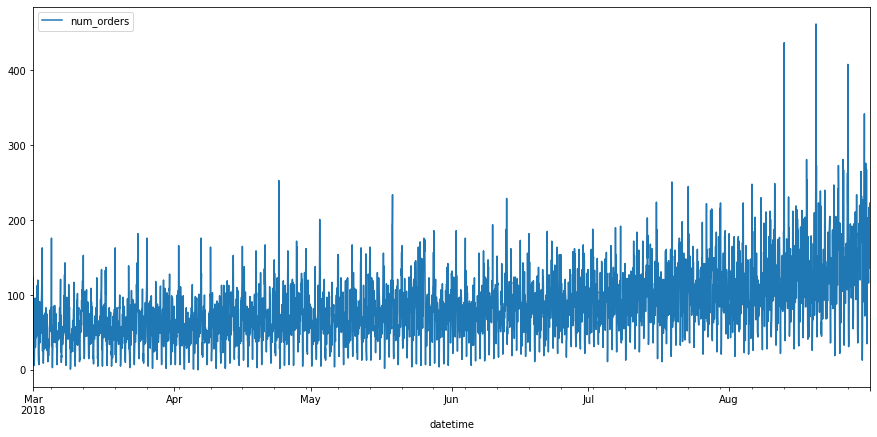

In [12]:
df.plot(figsize=(15,7))

Значения сливаются и на графике совсем ничего не понятно. Создадим новую переменную, в которую сохраним копию датафрейма, чтобы вносить изменения, добавим столбец со скользящим средним и построим новый график

In [13]:
new_df = df.copy()

Добавим столбец со скользящим средним, в качестве размера окна установим 12 часов (половину суток.)

In [14]:
new_df['rolling_mean'] = new_df.rolling(12).mean()

Так как после применения скользящего среднего в таблице появились пропуски, их нужно удалить.

In [15]:
new_df = new_df.dropna()

Теперь построим обновлённый график.

<AxesSubplot:xlabel='datetime'>

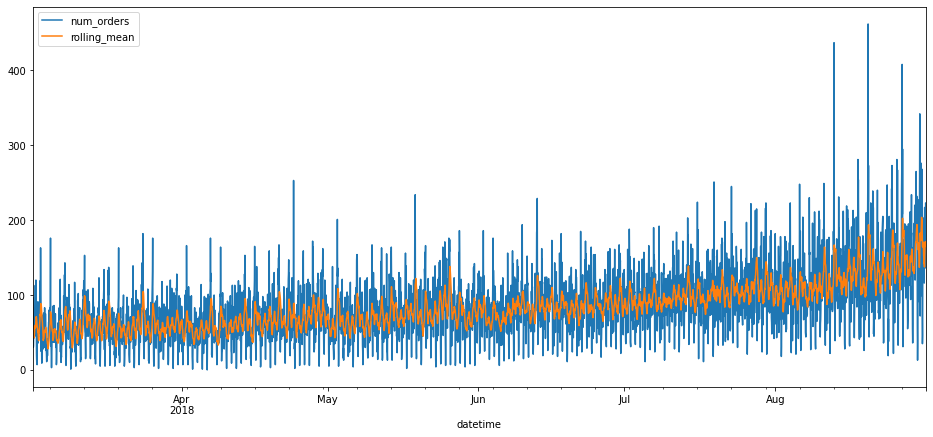

In [16]:
new_df.plot(figsize=(16,7))

На графике можно заметить, что скользящее среднее увеличивается, значит, временной ряд не стационарный. Также необходимо проверить тренд, возможно, увеличение количества заказов такси связано с летними месяцами.

In [18]:
decomposed = seasonal_decompose(new_df['num_orders'])

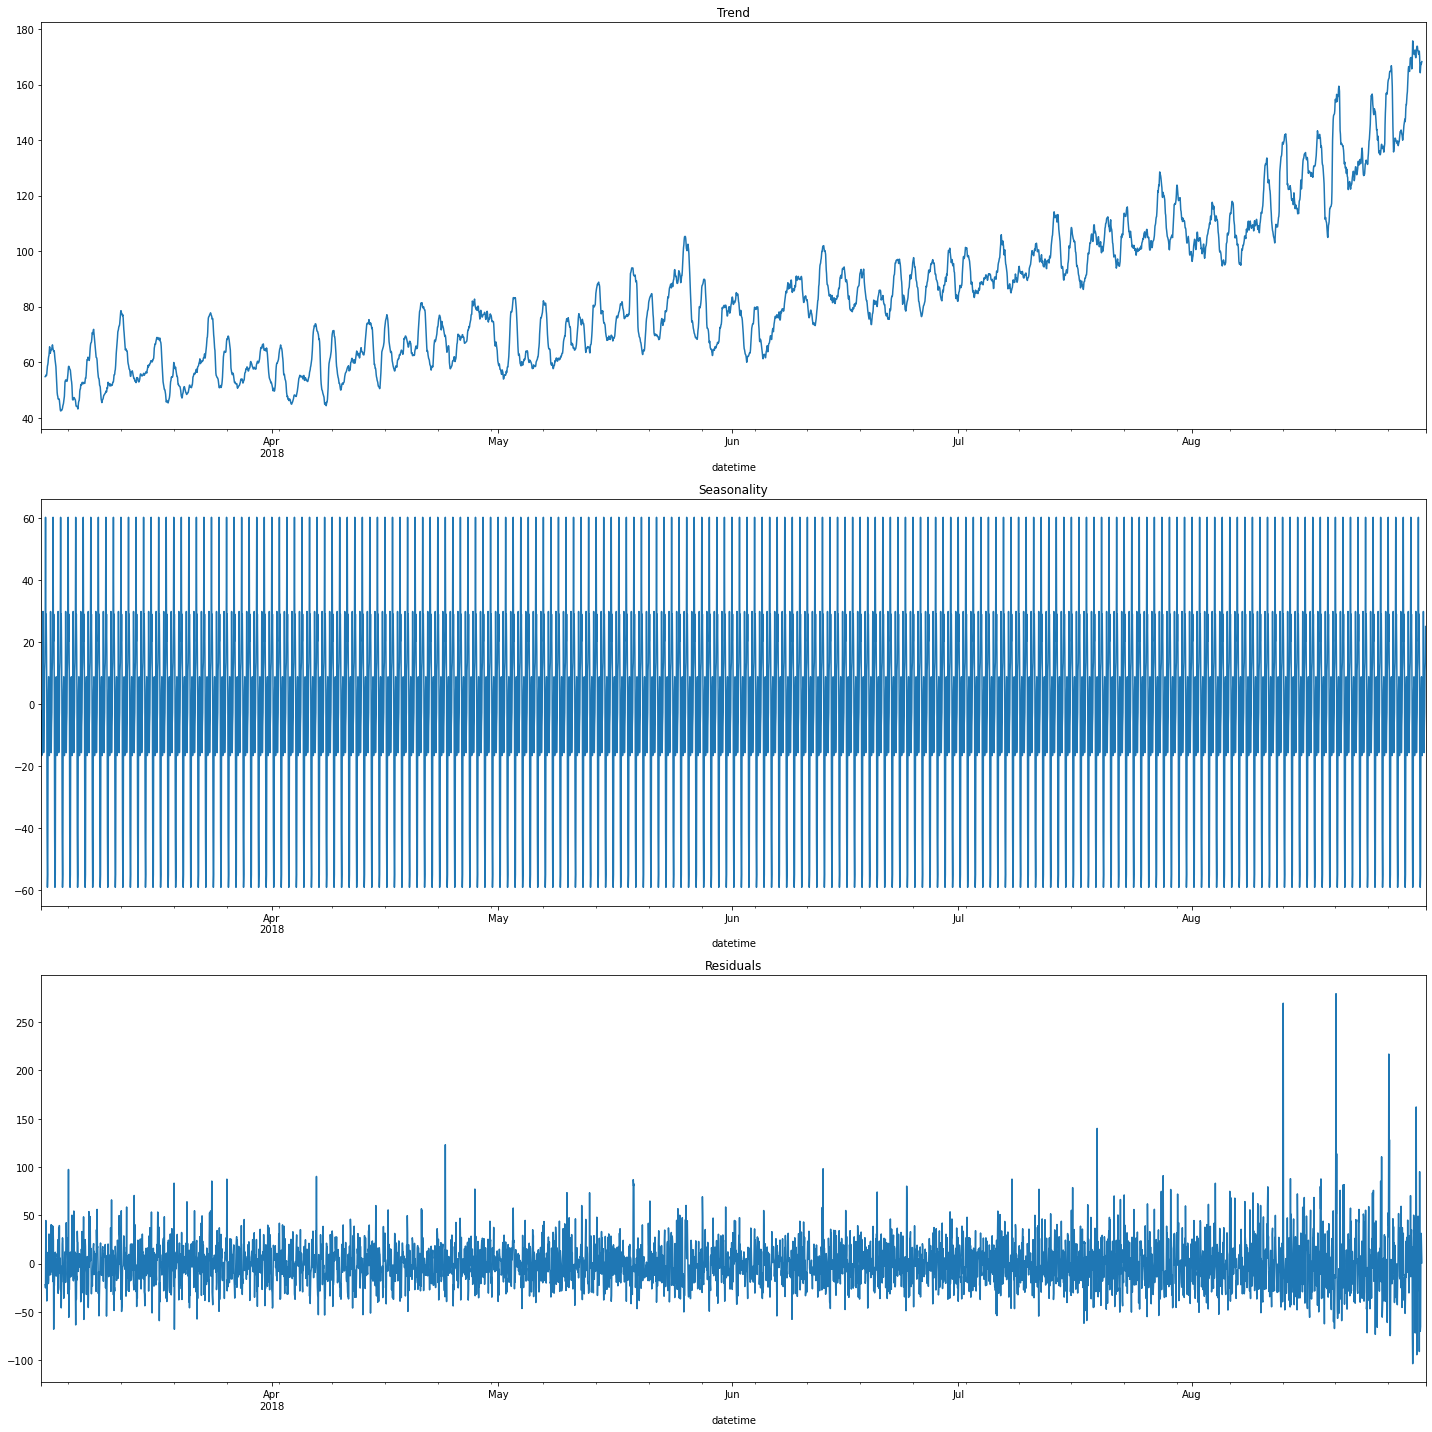

In [19]:
plt.figure(figsize=(20, 20))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Мы можем заметить восходящий тренд.

Рассмотрим сезонность подробнее в течение одного дня.

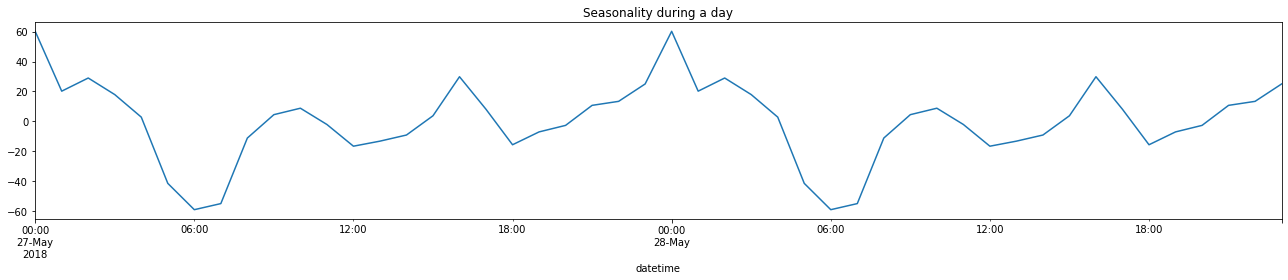

In [20]:
plt.figure(figsize=(18, 4))
decomposed.seasonal['2018-05-27':'2018-05-28'].plot(ax=plt.gca())
plt.title('Seasonality during a day')
plt.tight_layout()

Здесь мы можем заметить, что в 6:00 часов меньше всего заказов, тогда как в 00:00 часов их больше всего, рост начинается после 18 часов. Возможнно, этот связано с работой общественного транспорта, автобус может курсировать из аэропорта в город, его первый рейс в таком случае начинается около 6 часов, а после 18 часов интервал движения увеличивается до последнего рейса.

**Вывод:**

Исходя из анализа данных можно сказать, что в данных присутствует восходящий тренд. Если рассматривать сезонность на примере одного случайно выбранного дня, то в 6:00 часов самое минимальное количество заказов такси, а после 18:00 часов оно начинает расти и достигает своего пика в 00:00 часов. Перейдём к обучению моделей.

## Обучение

Для начала создадим новые признаки: месяц, день, день недели, час, лаги(отставания), скользящее среднее.

In [14]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()
    df.dropna(inplace=True)

In [15]:
make_features(df, 10, 10)

Теперь разделим данные на обучающую и тестовую выборки.

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
test = test.dropna()

Разделим тестовую выборку на тестовую и валидационную.

In [17]:
test, valid = train_test_split(test, shuffle=False, test_size=0.5)
valid = valid.dropna()

In [18]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

Перейдём к обучению моделей. Обучим с помощью линейной регрессии.

In [19]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)

CPU times: user 6.49 ms, sys: 826 µs, total: 7.32 ms
Wall time: 4.61 ms


LinearRegression()

Оценим RMSE.

In [20]:
%%time
lnr_pred = model.predict(features_valid)
print('RMSE : {:.2f}'.format(mse(target_valid, lnr_pred)**0.5))

RMSE : 50.90
CPU times: user 4.31 ms, sys: 67 µs, total: 4.38 ms
Wall time: 3.54 ms


Теперь обучим XGBRegressor.

In [21]:
def xgb_regr(features, target):
    model = XGBRegressor()
    params = {
        'max_depth': [3, 5, 7], 
         'eta': [0.5], 
         'min_child_weight':[4],
         'sampling_method':['gradient_based'], 
         'verbosity':[1],  
         'seed':[12345]}
    tscv = TimeSeriesSplit()
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=tscv,n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, eval_metric='rmse', verbose = 10)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('Best RMSE score: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [22]:
%%time
xgb_params = xgb_regr(features_train, target_train)

Best hyperparams:  {'eta': 0.5, 'max_depth': 3, 'min_child_weight': 4, 'sampling_method': 'gradient_based', 'seed': 12345, 'verbosity': 1}
Best RMSE score: 26.68
CPU times: user 55.8 s, sys: 405 ms, total: 56.2 s
Wall time: 56.7 s


In [23]:
%%time
model_xgb = XGBRegressor()
model_xgb.fit(features_train, target_train, eval_metric='rmse', verbose = 10)

CPU times: user 4.57 s, sys: 32.7 ms, total: 4.6 s
Wall time: 4.62 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Оценим RMSE.

In [24]:
%%time
xgb_pred = model_xgb.predict(features_valid)
print('RMSE : {:.2f}'.format(mse(target_valid, xgb_pred)**0.5))

RMSE : 56.25
CPU times: user 3.53 ms, sys: 7.32 ms, total: 10.8 ms
Wall time: 54.7 ms


Обучим модель LGBMRegressor.

In [35]:
def lgb_regr(features, target):
    model = LGBMRegressor()
    params = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : [50, 100],
        'max_depth' : [5, 7, 10],
        'verbose' : [0],
        'random_state' : [12345],
        'force_col_wise': [True],
        'num_leaves' : [127]}
    tscv = TimeSeriesSplit() 
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=tscv, n_jobs=-1)
    grid_cv.fit(features, target)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [36]:
%%time
lgb_params = lgb_regr(features_train, target_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/tmp/ipykernel_31/4210076644.py:14: RuntimeWarning: invalid value encountered in double_scalars
  print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))


In [37]:
%%time
model_lgb = LGBMRegressor(**lgb_params)
model_lgb.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=10, eval_metric='rmse')

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's rmse: 43.0817	valid_0's l2: 1856.04
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

LGBMRegressor(force_col_wise=True, max_depth=5, num_leaves=127,
              random_state=12345, verbose=0)

Оценим RMSE.

In [38]:
%%time
predict_lgb = model_lgb.predict(features_valid)
print('Valid RMSE = {:.2f}'.format(mse(target_valid, predict_lgb)**0.5))

Valid RMSE = 52.51
CPU times: user 20.9 ms, sys: 0 ns, total: 20.9 ms
Wall time: 6.75 ms


Обучим модель CatBoostRegressor.

In [12]:
def catboost_regr(features, target):
    model = CatBoostRegressor()
    params = {
            'n_estimators' : [50, 100],
            'verbose' : [0],
            'random_state' : [12345],
            'max_depth' : [5, 7, 10]
    }
    tscv = TimeSeriesSplit() 
    grid_cv = GridSearchCV(estimator=model, 
                    
    param_grid=params, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_cv.fit(features, target, verbose=10)
    print('Best hyperparams: ', grid_cv.best_params_)
    print('RMSE score on train sample: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))
    return grid_cv.best_params_

In [19]:
%%time
catb_params = catboost_regr(features_train, target_train)

Learning rate set to 0.43001
0:	learn: 24.4423081	total: 48.1ms	remaining: 2.35s
10:	learn: 15.6504996	total: 58.2ms	remaining: 206ms
20:	learn: 13.0529276	total: 68.3ms	remaining: 94.4ms
30:	learn: 11.0467578	total: 78.3ms	remaining: 48ms
40:	learn: 9.3478677	total: 88.1ms	remaining: 19.3ms
49:	learn: 8.2852580	total: 97ms	remaining: 0us
Learning rate set to 0.479585
0:	learn: 26.2459105	total: 1.73ms	remaining: 84.6ms
10:	learn: 16.9045492	total: 13.9ms	remaining: 49.4ms
20:	learn: 14.7249424	total: 26.4ms	remaining: 36.5ms
30:	learn: 13.0017280	total: 40.9ms	remaining: 25.1ms
40:	learn: 11.5258741	total: 54.5ms	remaining: 12ms
49:	learn: 10.5507811	total: 67ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 26.2468324	total: 1.83ms	remaining: 89.6ms
10:	learn: 18.7813634	total: 16.1ms	remaining: 57.1ms
20:	learn: 16.8944084	total: 29.8ms	remaining: 41.2ms
30:	learn: 15.2080916	total: 43.7ms	remaining: 26.8ms
40:	learn: 14.3939114	total: 57.3ms	remaining: 12.6ms
49:	learn: 13.18119

In [20]:
%%time
catb_model = CatBoostRegressor(**catb_params)
catb_model.fit(features_train, target_train, verbose=10)

Learning rate set to 0.324636
0:	learn: 30.6135823	total: 2.08ms	remaining: 206ms
10:	learn: 22.2864041	total: 21.7ms	remaining: 176ms
20:	learn: 21.1169155	total: 39.9ms	remaining: 150ms
30:	learn: 19.9742750	total: 58ms	remaining: 129ms
40:	learn: 19.0394271	total: 76.7ms	remaining: 110ms
50:	learn: 18.3638165	total: 94.1ms	remaining: 90.4ms
60:	learn: 17.8369592	total: 111ms	remaining: 70.9ms
70:	learn: 17.3086348	total: 128ms	remaining: 52.3ms
80:	learn: 16.8081790	total: 146ms	remaining: 34.2ms
90:	learn: 16.2901562	total: 163ms	remaining: 16.1ms
99:	learn: 15.9615494	total: 179ms	remaining: 0us
CPU times: user 206 ms, sys: 3.08 ms, total: 209 ms
Wall time: 834 ms


Оценим RMSE.

In [21]:
%%time
catb_pred = catb_model.predict(features_valid)
print('Valid RMSE : {:.2f} '.format(mse(target_valid, catb_pred)**0.5))

Valid RMSE : 54.39 
CPU times: user 0 ns, sys: 3.58 ms, total: 3.58 ms
Wall time: 2.53 ms


**Вывод:**

В ходе обучения мы обучили четыре различных модели, оценили их по RSME. Лучше других себя показала модель линейной регрессии, протестируем её на тестовой выборке.

## Тестирование

Протестируем модель линейной регрессии.

In [45]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)
lnr_pred = model.predict(features_test)
print('RMSE : {:.2f}'.format(mse(target_test, lnr_pred)**0.5))

RMSE : 40.39
CPU times: user 10.2 ms, sys: 3.85 ms, total: 14.1 ms
Wall time: 7.56 ms


Мы видим, что значение RSME допустимое, 40.39, что подходит под условия проекта.

## Вывод

Итак, в ходе выполнения проекта мы: 
1. изучили общую информацию о датасете
2. ресемплировали данные по часу
3. проанализировали данные и выявили восходящий тренд, а также если рассматривать сезонность на примере одного случайно выбранного дня, то в 6:00 часов самое минимальное количество заказов такси, а после 18:00 часов оно начинает расти и достигает своего пика в 00:00 часов 
4. обучили две модели и выбрали из них наилучшую
5. протестировали модель